In [13]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from textwrap import dedent
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [14]:
def build_combined_df():
    # ----- NPS CSV (paste from prompt) -----
    nps_csv = io.StringIO(dedent("""
    Airline,Q1 2024 NPS (est.),Q2 2024 NPS (est.),Q3 2024 NPS,Q4 2024 NPS (est.)
    JetBlue,50,48,50,52
    Alaska,52,51,53,54
    Southwest,51,50,52,53
    Delta,49,48,50,51
    United,42,40,45,46
    American,25,24,26,27
    """).strip())
    nps_df = pd.read_csv(nps_csv)

    # ----- Baggage revenue CSV (subset for airlines present in NPS table) -----
    # Values are in thousands
    revenue_data = [
        {"Airline": "Alaska",   "1Q": "83,934",  "2Q": "106,033", "3Q": "118,372", "4Q": "98,236",  "2024": "406,575"},
        {"Airline": "American", "1Q": "334,743", "2Q": "394,435", "3Q": "389,782", "4Q": "382,369", "2024": "1,501,329"},
        {"Airline": "Delta",    "1Q": "239,012", "2Q": "289,749", "3Q": "259,227", "4Q": "272,113", "2024": "1,060,101"},
        {"Airline": "JetBlue",  "1Q": "142,559", "2Q": "158,987", "3Q": "177,864", "4Q": "143,084", "2024": "622,494"},
        {"Airline": "Southwest","1Q": "18,990",  "2Q": "21,769",  "3Q": "21,364",  "4Q": "20,956",  "2024": "83,079"},
        {"Airline": "United",   "1Q": "300,800", "2Q": "346,431", "3Q": "352,933", "4Q": "334,933", "2024": "1,335,096"},
    ]
    rev_df = pd.DataFrame(revenue_data)

    # Clean revenue numeric columns
    for col in ["1Q", "2Q", "3Q", "4Q", "2024"]:
        rev_df[col] = rev_df[col].str.replace(",", "", regex=False).astype(int)

    # ----- Reshape & merge on Airline + Quarter -----
    # NPS → long with quarter number
    nps_long = nps_df.melt(
        id_vars="Airline",
        var_name="NPS_Quarter_Label",
        value_name="NPS"
    )
    quarter_map = {
        "Q1 2024 NPS (est.)": 1,
        "Q2 2024 NPS (est.)": 2,
        "Q3 2024 NPS": 3,
        "Q4 2024 NPS (est.)": 4
    }
    nps_long["Quarter"] = nps_long["NPS_Quarter_Label"].map(quarter_map)

    # Revenue → long with quarter number
    rev_long = rev_df.melt(
        id_vars="Airline",
        value_vars=["1Q", "2Q", "3Q", "4Q"],
        var_name="Rev_Quarter_Label",
        value_name="Revenue_Thou"
    )
    rev_quarter_map = {"1Q": 1, "2Q": 2, "3Q": 3, "4Q": 4}
    rev_long["Quarter"] = rev_long["Rev_Quarter_Label"].map(rev_quarter_map)

    combined = pd.merge(nps_long, rev_long, on=["Airline", "Quarter"], how="inner")
    combined = combined[["Airline", "Quarter", "NPS", "Revenue_Thou"]].sort_values(
        ["Airline", "Quarter"]
    ).reset_index(drop=True)

    return combined

In [15]:
def fit_and_plot_linear(combined: pd.DataFrame):
    X = combined[["NPS"]].values  # shape (n,1)
    y = combined["Revenue_Thou"].values.astype(float)  # thousands

    lin = LinearRegression().fit(X, y)
    y_pred = lin.predict(X)
    r2 = r2_score(y, y_pred)

    print("Linear model (original scale): Revenue_thousands = a + b * NPS")
    print(f"  Intercept (a): {lin.intercept_:.2f}")
    print(f"  Slope (b):     {lin.coef_[0]:.2f}")
    print(f"  R^2:           {r2:.4f}\n")

    # Scatter + fitted line
    plt.figure(figsize=(7,5))
    plt.scatter(X, y)
    x_grid = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
    plt.plot(x_grid, lin.predict(x_grid))
    plt.title("Baggage Revenue (thousands) vs. NPS")
    plt.xlabel("NPS")
    plt.ylabel("Baggage Revenue (thousands)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Residuals
    residuals = y - y_pred
    plt.figure(figsize=(7,5))
    plt.scatter(y_pred, residuals)
    plt.axhline(0)
    plt.title("Residuals vs. Fitted (Linear, original scale)")
    plt.xlabel("Fitted Revenue (thousands)")
    plt.ylabel("Residual (thousands)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [16]:
def fit_and_plot_log_transform(combined: pd.DataFrame):
    """
    Apply a log transform to revenue and re-fit:
        log10(Revenue_thousands) = a + b * NPS
    """
    X = combined[["NPS"]].values
    y = combined["Revenue_Thou"].values.astype(float)

    # Ensure positivity (required for log). Data here are positive.
    y_log10 = np.log10(y)

    lin_log = LinearRegression().fit(X, y_log10)
    y_log_pred = lin_log.predict(X)
    r2_log = r2_score(y_log10, y_log_pred)

    print("Log-transformed model: log10(Revenue_thousands) = a + b * NPS")
    print(f"  Intercept (a): {lin_log.intercept_:.4f}")
    print(f"  Slope (b):     {lin_log.coef_[0]:.4f}")
    print(f"  R^2:           {r2_log:.4f}\n")

    # Optional: visualize on log scale (scatter in original X with log10(y))
    plt.figure(figsize=(7,5))
    plt.scatter(X, y_log10)
    x_grid = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
    plt.plot(x_grid, lin_log.predict(x_grid))
    plt.title("log10(Baggage Revenue in thousands) vs. NPS")
    plt.xlabel("NPS")
    plt.ylabel("log10(Revenue_thousands)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    Airline  Quarter  NPS  Revenue_Thou
0    Alaska        1   52         83934
1    Alaska        2   51        106033
2    Alaska        3   53        118372
3    Alaska        4   54         98236
4  American        1   25        334743 

Linear model (original scale): Revenue_thousands = a + b * NPS
  Intercept (a): 672096.68
  Slope (b):     -10212.71
  R^2:           0.5744



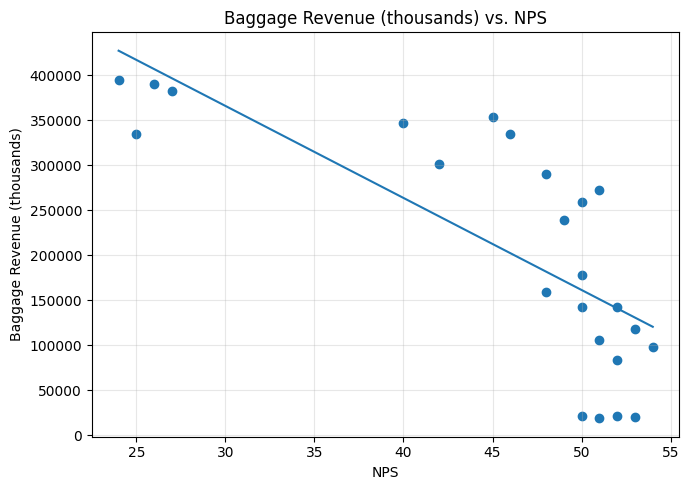

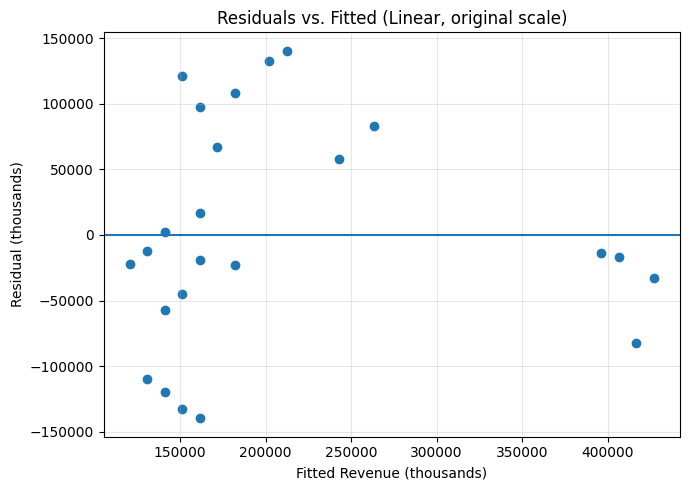

Log-transformed model: log10(Revenue_thousands) = a + b * NPS
  Intercept (a): 6.3546
  Slope (b):     -0.0261
  R^2:           0.3288



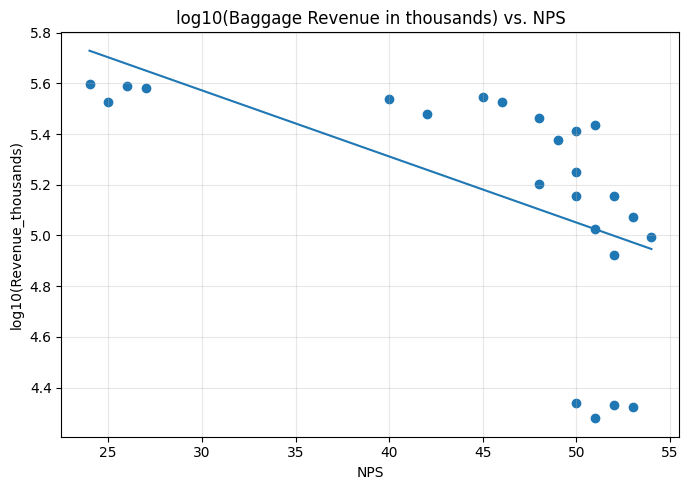

In [17]:
if __name__ == "__main__":
    combined_df = build_combined_df()
    print(combined_df.head(), "\n")
    # Save if you want to inspect/join later
    combined_df.to_csv("nps_baggage_combined_2024.csv", index=False)

    fit_and_plot_linear(combined_df)
    fit_and_plot_log_transform(combined_df)